### Detail description is in problem1_a_Mathematical_Solutions_&_Verification.pdf (but is Chinese)

In [5]:
import numpy as np

import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
from scipy.optimize import fsolve
from scipy.integrate import quad
import scipy.integrate as integrate

# for plot and stimulate
def simulate_squid_game_v2(L, N, p, T):
    """
    Simulate the Squid Game scenario for T turns.
    
    Parameters:
    - L (int): Max number of players that can be sent back to the start line
    - N (int): Total number of players
    - p (list): List of N probabilities of failing to freeze for each player
    - T (int): Number of turns to simulate
    
    Returns:
    dict: A dictionary where the keys are player indices and the values are dictionaries.
          The inner dictionaries have keys as positions and values as the probability of 
          each player being in that position after T turns.
    """
    # Initialize players' positions
    positions = np.zeros(N, dtype=int)
    
    # Store the history of each player's position
    history = np.zeros((N, T+1), dtype=int)
    
    # Simulate the game for T turns
    for t in range(T):
        # Move all players one step forward
        positions += 1
        
        # Determine which players failed to freeze
        failed_to_freeze = np.random.rand(N) < p
        
        # If more than L players failed to freeze, find the L players who traveled the farthest
        if np.sum(failed_to_freeze) > L:
            # Find the indices of the L players who traveled the farthest and failed to freeze
            farthest_failed_indices = np.argsort(positions * failed_to_freeze)[-L:]
            
            # Send them back to the starting line
            positions[farthest_failed_indices] = 0
        else:
            # Send all players who failed to freeze back to the starting line
            positions[failed_to_freeze] = 0
        
        # Update history
        history[:, t+1] = positions
        
    # Calculate the probability distributions for each player
    prob_distributions = {}
    for i in range(N):
        # Count occurrences of each position and divide by T to get probabilities
        unique, counts = np.unique(history[i, :], return_counts=True)
        prob_distributions[i] = dict(zip(unique, counts))
    
    return prob_distributions

def plot_simulation_vs_estimate(p, result, probabilities_estimated, people_order=0, T=1000000):
    """
    Plot the simulated and estimated probabilities along with their relative error and absolute error.
    
    Parameters:
    - result (dict): Output from the simulate_squid_game_v2 function
    - p (list): List of N probabilities of failing to freeze for each player
    
    Returns:
    None
    """
    # Extract position probabilities for player 0 from simulation
    positions_simulated = list(result[people_order].keys())
    probabilities_simulated = list(result[people_order].values())
    probabilities_simulated = np.array(probabilities_simulated) / T

    # Estimate probabilities for the same positions
    # probabilities_estimated = [estimate(p[people_order], k) for k in positions_simulated]

    # Calculate relative errors and absolute errors
    rel_errors = [abs(est - sim) / sim for est, sim in zip(probabilities_estimated, probabilities_simulated)]
    abs_errors = [abs(est - sim) for est, sim in zip(probabilities_estimated, probabilities_simulated)]

    # Create plots
    plt.figure(figsize=(15, 10))  # Adjusted figure size to accommodate 3 subplots

    # Plot probabilities
    plt.subplot(2, 2, 1)
    plt.plot(positions_simulated, probabilities_simulated, label='Simulated')
    plt.plot(positions_simulated, probabilities_estimated, label='Estimated', linestyle='--')
    plt.xlabel(f"Position (k), Np={p[people_order]*len(p)}")
    plt.ylabel('Probability')
    plt.title('Probabilities: Simulated vs. Estimated')
    plt.legend()

    # Plot relative errors
    plt.subplot(2, 2, 2)
    plt.plot(positions_simulated, rel_errors, label='Rel. Error', color='red')
    plt.xlabel(f"Position (k), Np={p[people_order]*len(p)}")
    plt.ylabel('Relative Error')
    plt.title('Relative Error: Simulated vs. Estimated')
    plt.legend()
    
    # Plot absolute errors
    plt.subplot(2, 2, 3)  # New subplot for absolute errors
    plt.plot(positions_simulated, abs_errors, label='Abs. Error', color='blue')
    plt.xlabel(f"Position (k), Np={p[people_order]*len(p)}")
    plt.ylabel('Absolute Error')
    plt.title('Absolute Error: Simulated vs. Estimated')
    plt.legend()

    # Display plots
    plt.tight_layout()
    plt.show()

# for estimate in a)

def custom_integral(mu, sigma, l, num):
    """
    Compute the integral of PDF(x) * (num+x-l)dx from (l-num) to l
    where PDF(x) is the PDF of a normal distribution with mean mu and standard deviation sigma
    
    Parameters:
    mu (float): mean of the normal distribution
    sigma (float): standard deviation of the normal distribution
    l (float): upper limit of the integral
    num (float): range of the integral
    
    Returns:
    float: result of the integral
    """
    # 定义被积函数
    def integrand(x, mu, sigma, l, num):
        pdf = norm.pdf(x, mu, sigma)  # 计算正态分布的概率密度函数
        return pdf * (l-x)
    
    # 计算积分
    result, _ = quad(integrand, l-num, l, args=(mu, sigma, l, num))
    result += norm.cdf(l, mu, sigma) * (num)
    #print(norm.cdf(l-num, mu, sigma))
    return result

def custom_integral_true_L(mu, sigma, l):
    """
    Compute the integral of PDF(x) * (num+x-l)dx from (l-num) to l
    where PDF(x) is the PDF of a normal distribution with mean mu and standard deviation sigma
    
    Parameters:
    mu (float): mean of the normal distribution
    sigma (float): standard deviation of the normal distribution
    l (float): upper limit of the integral
    num (float): range of the integral
    
    Returns:
    float: result of the integral
    """
    # 定义被积函数
    def integrand1(x, mu, sigma, l):
        pdf = norm.pdf(x, mu, sigma)  # 计算正态分布的概率密度函数
        return pdf * x
    
    def integrand2(x, mu, sigma, l):
        pdf = norm.pdf(x, mu, sigma)  # 计算正态分布的概率密度函数
        return pdf
    
    # 计算积分
    result1, _ = quad(integrand1, -np.inf, l, args=(mu, sigma, l))
    result2, _ = quad(integrand2, l, np.inf, args=(mu, sigma, l))
    print(result1, result2*l)
    return result1+result2*l

def find_init_people(L,N,p):
    mu=N*p
    sigma=np.sqrt(N*p*(1-p))
    return custom_integral_true_L(mu, sigma, L)

def estimate_equal_p(L,N,p,T=1000000):
    p_list=[p]*N
    result= simulate_squid_game_v2(L, N, p_list, T)
    positions_simulated = list(result[0].keys())
    cur_num=find_init_people(L,N,p)
    predict_num=N
    probabilities_estimated=np.array([cur_num])
    total_sum=0
    while len(probabilities_estimated)<len(positions_simulated):
        total_sum+=cur_num
        predict_num-=cur_num
        mu=predict_num*p
        sigma=(predict_num*p*(1-p))**0.5
        integral=custom_integral(mu, sigma, L, cur_num*p)
        cur_num=cur_num-integral
        probabilities_estimated=np.append(probabilities_estimated, cur_num)

    probabilities_estimated/=N
    plot_simulation_vs_estimate(p_list, result, probabilities_estimated, people_order=0, T=T)
    #return probabilities_estimated
    
    

### Verification

0.0001246417916752512 19.99986562550236


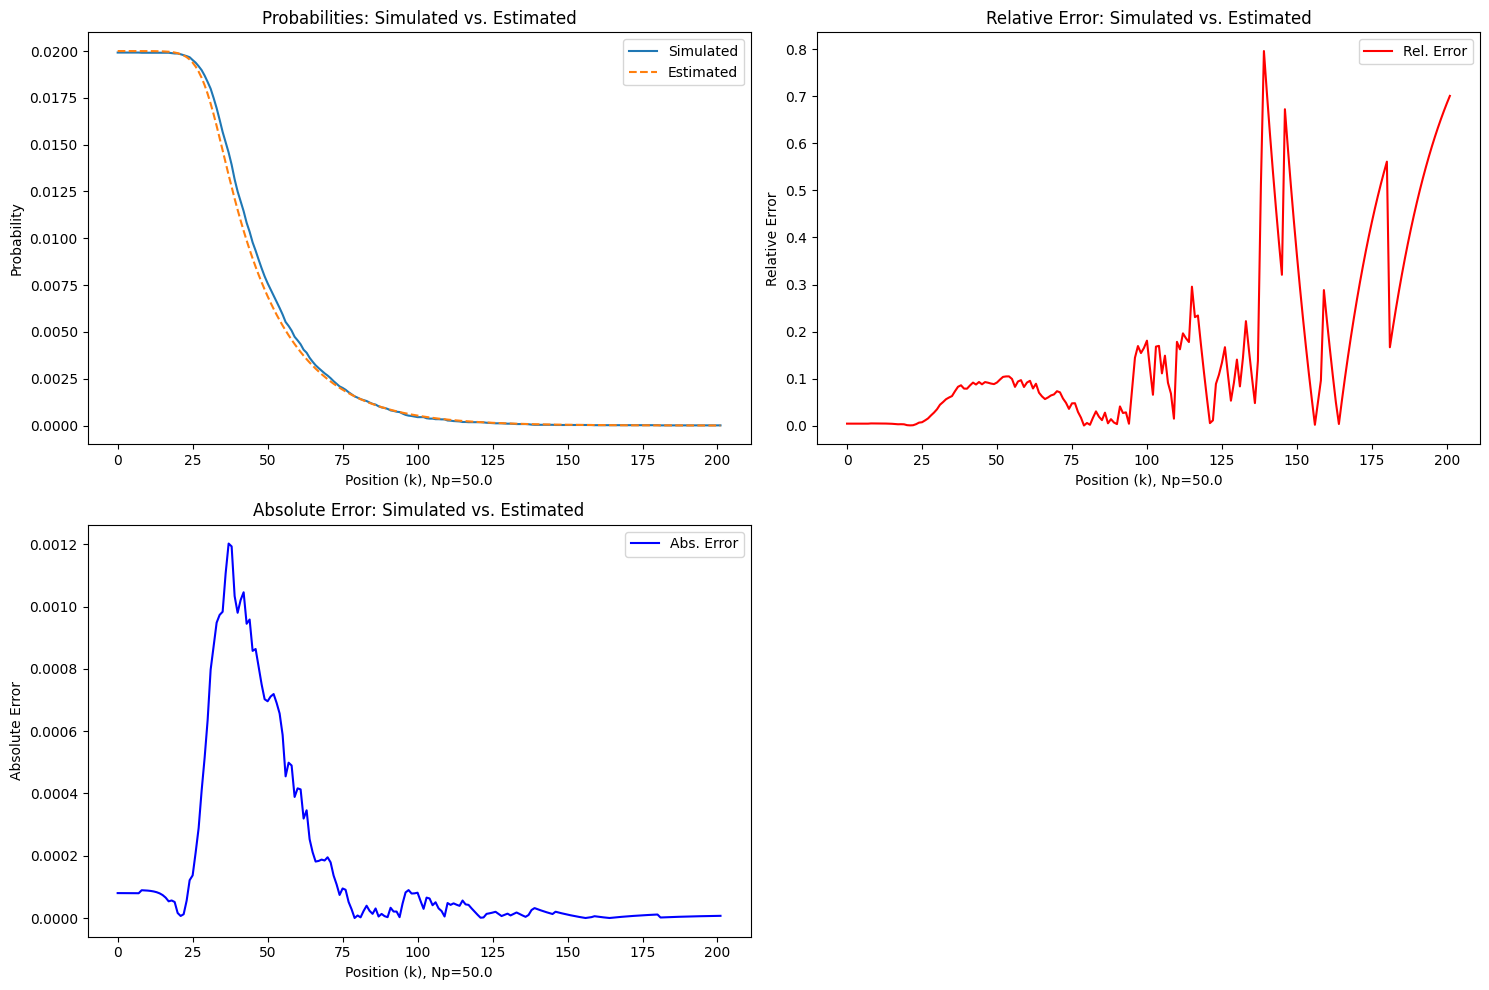

In [18]:
L=20
N=1000
p=0.05
estimate_equal_p(L,N,p,T=100000)